# High Quality Images Classification 

This notebook contains the code used to train a CNN model on high quality mound images, as selected by a human annotator. The trained model is then run across the full image collection to provide predictions of whether the area contains a mound or not. 

The notebook is split into the following sections: 
- Part 1: Setup 
- Part 2: Train the model 
- Part 3: Generate Predictions on Test Data 
- Part 4: Generate Predictions across Full Dataset 


## Part 1: Setup 

_If using notebook without virtual environment_

In [3]:
#!pip install tensorflow
#!pip install matplotlib
#!pip install sklearn

#### Dependencies 

In [4]:
#Operating system 
import os
import sys

#Data handling packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.resnet50 import (preprocess_input,
                                                    decode_predictions,
                                                    ResNet50)

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout,
                                     Conv2D,
                                     Activation, 
                                     MaxPooling2D)

# generic model object
from tensorflow.keras.models import Model, Sequential

# optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1,l2,l1_l2

# early stopping 
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 2)

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

# for plotting
import numpy as np
import matplotlib.pyplot as plt

2022-03-07 08:24:49.546310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 08:24:49.546386: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Paths 

_The output paths will be located in the 'Analysis 2022' folder_

In [13]:
# -- output path -- 
output_directory = '/work/proj/Analysis_2022/output'

# -- image directory -- 
train_data_dir = '/work/proj/Analysis_2022/data/model_data/train/'
test_data_dir = '/work/proj/Analysis_2022/data/model_data/test/'

# Check the folders in the train and test directory 
print(f"The training directory contains {len(os.listdir(train_data_dir))} folders which are {os.listdir(train_data_dir)}.")
print(f"The test directory contains {len(os.listdir(test_data_dir))} folders which are {os.listdir(test_data_dir)}.")


# output paths 
report_directory = '/work/proj/Analysis_2022/output/classification_reports/'
plot_directory = '/work/proj/Analysis_2022/output/history_plots/'
csv_directory = '/work/proj/Analysis_2022/output/csv_files/'


The training directory contains 2 folders which are ['NEG', 'MND'].
The test directory contains 2 folders which are ['NEG', 'MND'].


#### Functions 

In [14]:
# -- Function for loading data -- 
def load_data(train_data_dir, 
              test_data_dir, 
              batch_size=32, 
              img_height=150, 
              img_width=150, 
              split=0.2):
    """
    Load training, validation, and testing datasets
    
    Training data is augmented using augmentation layer
    """
    # Training
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                  train_data_dir,
                  validation_split=0.2,
                  subset="training",
                  color_mode="rgb",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)
    
    # Validation
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                  train_data_dir,
                  validation_split=0.2,
                  subset="validation",
                  color_mode="rgb",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)

    # Test
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                    test_data_dir,
                    color_mode="rgb",
                    shuffle=False,
                    image_size=(img_height, img_width))
    
    # Augment training data
    data_augmentation = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),])
    # Augmented dataset
    aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    return aug_ds, val_ds, test_ds

In [1]:
# -- Function for building and compiling model -- 
def cnn_model(train_ds, val_ds):
    """
    Use pretrained CNN for transfer learning
    """
    # Clear backend
    tf.keras.backend.clear_session()
    
    # Set checkpoints - train on validation loss
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints", 
                                                    mode='min', 
                                                    monitor='val_loss', 
                                                    verbose=1, 
                                                    save_best_only=True)
    # Get list of callback checkpoints
    callbacks_list = [checkpoint]
    
    # load model without classifier layers
    model = ResNet50(include_top=False, 
                      pooling='avg',
                      input_shape=(150, 150, 3))
    
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
        
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, 
                   activation='relu', 
                   kernel_regularizer=l2(0.0001), 
                   bias_regularizer=l2(0.0001))(flat1)
    drop1 = Dropout(0.2)(class1)
    output = Dense(1, activation='sigmoid')(class1)

    # define new model
    model = Model(inputs=model.inputs, 
                  outputs=output)
    
    #sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy',
                           tf.keras.metrics.AUC()])
    
    # Fit model
    H = model.fit(train_ds,
                  validation_data=val_ds, 
                  batch_size=32,
                  epochs=100,   # set a high number as we have early stopping 
                  verbose=1,
                  callbacks=[early_stopping]) # patience of 2 
    
    # show history
    #plot_history(H, 15)
    
    return model, H

In [17]:
# -- Function to make predictions -- 
def predict_unseen(model, test_ds):
    """
    Use trained model to predict unseen data
    """
    # Get predicted categories from model
    predicted_categories = (model.predict(test_ds) > 0.5).astype("int32")
    # Get actual categories from test_ds
    true_categories = tf.concat([y for x, y in test_ds], axis = 0).numpy()
    # sklearn classification report
    print(classification_report(true_categories, 
                                predicted_categories,
                                target_names=test_ds.class_names))
    
    # Save classification report
    with open(report_path, 'w', encoding='utf-8') as f:
        f.writelines(classification_report(true_categories,
                                           predicted_categories,
                                           target_names=test_ds.class_names))

In [18]:
# Function to create history plots 

def plot_history(history, epochs):
    """
    Function to create seaborn history plot
    """
    plt.style.use("seaborn")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="Training Loss")
    plt.plot(np.arange(0, epochs), H.history["binary_accuracy"], label="Training Accuracy")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="Validation Loss")
    plt.plot(np.arange(0, epochs), H.history["val_binary_accuracy"], label="Validation Accuracy")
    plt.title("Training Performance of CNN Model Across 30 Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss and Accuracy")
    plt.legend(loc="upper center", bbox_to_anchor=(1.25, 1.0), ncol=1)
    #plt.tight_layout()
    plt.show()
    #plt.savefig(figure_path)
    
def plot_history_save(history, epochs, figure_path):
    """
    Function to create seaborn history plot
    """
    plt.style.use("seaborn")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="Training Loss")
    plt.plot(np.arange(0, epochs), H.history["binary_accuracy"], label="Training Accuracy")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="Validation Loss")
    plt.plot(np.arange(0, epochs), H.history["val_binary_accuracy"], label="Validation Accuracy")
    plt.title("Training Performance of CNN Model Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss and Accuracy")
    plt.legend(loc="upper center", bbox_to_anchor=(1.25, 1.0), ncol=1)
    #plt.tight_layout()
    plt.savefig(figure_path)

#### Load data

In [19]:
# Load data
aug_ds, val_ds, test_ds = load_data(train_data_dir, test_data_dir)

Found 671 files belonging to 2 classes.
Using 537 files for training.
Found 671 files belonging to 2 classes.
Using 134 files for validation.
Found 100 files belonging to 2 classes.


In [20]:
# -- Inspect data types --
print(aug_ds)
print(test_ds)
print(val_ds)

<MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Part 2: Train the Model 

In [21]:
# -- Train model --
best_model, H = cnn_model(aug_ds, val_ds)

Epoch 1/100
17/17 [==============================] - 10s 467ms/step - loss: 0.3576 - binary_accuracy: 0.8808 - auc: 0.9242 - val_loss: 0.5805 - val_binary_accuracy: 0.6866 - val_auc: 0.9183
Epoch 2/100
17/17 [==============================] - 7s 408ms/step - loss: 0.1712 - binary_accuracy: 0.9553 - auc: 0.9898 - val_loss: 0.5975 - val_binary_accuracy: 0.6866 - val_auc: 0.9459
Epoch 3/100
17/17 [==============================] - 7s 409ms/step - loss: 0.1298 - binary_accuracy: 0.9683 - auc: 0.9941 - val_loss: 0.5728 - val_binary_accuracy: 0.6940 - val_auc: 0.9565
Epoch 4/100
17/17 [==============================] - 7s 406ms/step - loss: 0.1111 - binary_accuracy: 0.9739 - auc: 0.9975 - val_loss: 0.5726 - val_binary_accuracy: 0.6940 - val_auc: 0.9665
Epoch 5/100
17/17 [==============================] - 7s 385ms/step - loss: 0.0908 - binary_accuracy: 0.9777 - auc: 0.9989 - val_loss: 0.5100 - val_binary_accuracy: 0.7313 - val_auc: 0.9709
Epoch 6/100
17/17 [==============================] - 7

#### Visualise

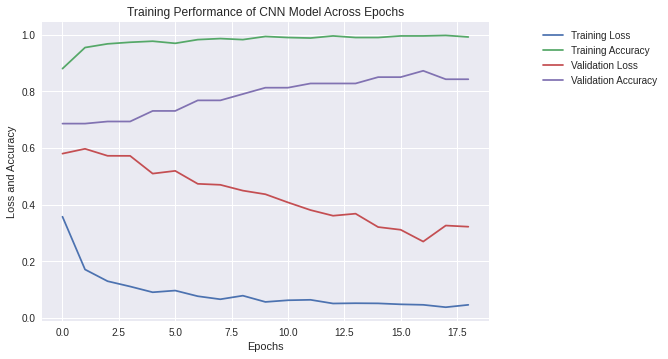

In [22]:
# -- path --
plot_early_stopping_path = '/work/proj/Analysis_2022/output/history_plots/early_stopping_plot.png' 

# -- save --
plot_history_save(H, 19, plot_early_stopping_path)

## Part 3: Generate Predictions 

In the below section, we test our model on the test set to see how well it performs on unseen data. From these predictions, we can extract the necessary information to record which images were classified correctly and which were not. We'll save this together with the image's filename into a csv file where the individual images can be manually inspected. 

#### Create predictions 

In [55]:
# -- Extract the raw predictions --
raw_predictions = best_model.predict(test_ds)  

In [56]:
# -- Categorise these into 0's and 1's -- 
categorised_predictions = []

for i in raw_predictions:
    if i >= 0.5:
        category = 1
    else:
        category = 0
    categorised_predictions.append(category) 

In [57]:
# -- Count how many predictions have been made for each category -- 
MND = 0 
NEG = 0 

for i in categorised_predictions:
    if i == 0:
        MND = MND + 1
    else: 
        NEG = NEG + 1  
        
print(f"There are {MND} predictions of category 'MND'.") 
print(f"And {NEG} predictions of category 'NEG'.") 

There are 22 predictions of category 'MND'.
And 78 predictions of category 'NEG'.


#### Check predictions against the true categories 

In [58]:
# -- Get the counts for the true categories -- 
true_categories = tf.concat([y for x, y in test_ds], axis = 0).numpy()

In [59]:
# -- Count how many images are truly in each category -- 
true_MND = 0
true_NEG = 0 

for i in true_categories:
    if i == 0:
        true_MND = true_MND + 1
    else:
        true_NEG = true_NEG + 1

print(f"There are {true_MND} true images of category 'MND'.") 
print(f"And {true_NEG} true images of category 'NEG'.") 

There are 49 true images of category 'MND'.
And 51 true images of category 'NEG'.


_We see that our model tends to overfit on the 'NEG' category, classifying more images in there than into the mounds. This is good, as it means our model is cautious, but it is missing a lot of the good information._

#### Make Classification report 

In [60]:
print(classification_report(true_categories,
                      categorised_predictions,
                      target_names=test_ds.class_names))

              precision    recall  f1-score   support

         MND       1.00      0.45      0.62        49
         NEG       0.65      1.00      0.79        51

    accuracy                           0.73       100
   macro avg       0.83      0.72      0.71       100
weighted avg       0.82      0.73      0.71       100



__Save classification report__

In [18]:
# path
report_30_path = report_directory + '30_epochs_classification_report.txt'

with open(report_30_path, 'w', encoding='utf-8') as f:
        f.writelines(classification_report(true_categories,
                                           categorised_predictions,
                                           target_names=test_ds.class_names))

## Make Dataframe of correct predictions 

In [19]:
# -- We can check what 0 and 1 stand for in terms of our test dataset --
print(f"0 stands for category {test_ds.class_names[0]}.")
print(f"1 stands for category {test_ds.class_names[1]}.")

0 stands for category MND.
1 stands for category NEG.


#### Get paths and filenames

In [20]:
# -- get paths to the test dataset folders --
MND_path = '/work/proj/Analysis_2022/data/model_data/test/MND'
NEG_path = '/work/proj/Analysis_2022/data/model_data/test/NEG'

# -- List the directories to count images -- 
MND_images = os.listdir(MND_path)
NEG_images = os.listdir(NEG_path)

In [21]:
# -- Check the number of images in each --
print(f"There are {len(MND_images)} images in the MND folder.") 
print(f"There are {len(NEG_images)} images in the NEG folder.") 

There are 49 images in the MND folder.
There are 51 images in the NEG folder.


In [22]:
# -- Get lists of the filenames in each directory --
from os import walk

#MND 
MND_filenames = next(walk(MND_path), (None, None, []))[2]

#NEG 
NEG_filenames = next(walk(NEG_path), (None, None, []))[2]

In [23]:
print(f"There are {len(MND_filenames)} filenames collected.\n[Example] {MND_filenames[0]}.\n")
print(f"There are {len(NEG_filenames)} filenames collected.\n[Example] {NEG_filenames[0]}.\n")

There are 49 filenames collected.
[Example] RGB_354102.615446188.png.

There are 51 filenames collected.
[Example] IMG_354515.5000_4720534.5000_150.png.



In [24]:
# -- Create label variables --
MND_label = ['Mound'] * 49
NEG_label = ['Not Mound'] * 51

In [25]:
# Compile this information of 2 ordered lists 
df_labels = MND_label + NEG_label 
print(f"This has created a list of {len(df_labels)} labels.") 

df_filenames = MND_filenames + NEG_filenames
print(f"And a list of {len(df_filenames)} filenames.") 

This has created a list of 100 labels.
And a list of 100 filenames.


In [26]:
# Create a dataframe of the necessary information 
df = pd.DataFrame()

df['Category'] = df_labels
df['Image filename'] = df_filenames
df['True Category'] = true_categories
df['Raw prediction'] = raw_predictions
df['Categorised Prediction'] = categorised_predictions 

df[45:55]

,Category,Image filename,True Category,Raw prediction,Categorised Prediction
45,Mound,RGB_354188.615446188.png,0,0.028067,0
46,Mound,RGB_354532.615446188.png,0,0.122553,0
47,Mound,RGB_367380.615446188.png,0,0.252728,0
48,Mound,RGB_353305.615446188.png,0,0.581006,1
49,Not Mound,IMG_354515.5000_4720534.5000_150.png,1,0.999869,1
50,Not Mound,IMG_351305.5000_4727275.5000_150.png,1,0.996307,1
51,Not Mound,IMG_357673.5000_4715609.5000_150.png,1,0.995221,1
52,Not Mound,IMG_367572.5000_4720317.5000_150.png,1,0.999920,1
53,Not Mound,IMG_348126.5000_4727589.5000_150.png,1,0.998524,1
54,Not Mound,IMG_368092.5000_4716941.5000_150.png,1,0.995998,1


In [27]:
# Fix the data type of columns 
df['True Category'] = df['True Category']. astype(int) 
df['Categorised Prediction'] = df['Categorised Prediction']. astype(int) 

In [28]:
# Create column indicating whether prediction was correct or not
correct_prediction = []

for i, row in df.iterrows():
    true = row['True Category']
    predicted = row['Categorised Prediction']
    if true == predicted:
        result = 'Correct'
    else:
        result = 'Not Correct'
    correct_prediction.append(result) 

# Check all predictions have been accounted for 
print(len(correct_prediction))

100


In [29]:
# Add column onto dataframe 
df['Prediction'] = correct_prediction

In [30]:
df[:10]

,Category,Image filename,True Category,Raw prediction,Categorised Prediction,Prediction
0,Mound,RGB_354102.615446188.png,0,0.079849,0,Correct
1,Mound,RGB_352800.615446188.png,0,0.187671,0,Correct
2,Mound,RGB_352698.615446188.png,0,0.540431,1,Not Correct
3,Mound,RGB_360086.615446188.png,0,0.393541,0,Correct
4,Mound,RGB_359308.615446188.png,0,0.415371,0,Correct
5,Mound,RGB_356597.615446188.png,0,0.274331,0,Correct
6,Mound,RGB_355118.615446188.png,0,0.031488,0,Correct
7,Mound,RGB_362626.615446188.png,0,0.035304,0,Correct
8,Mound,RGB_355270.615446188.png,0,0.007492,0,Correct
9,Mound,RGB_365537.615446188.png,0,0.000146,0,Correct


#### Save csv 

In [31]:
df.to_csv(csv_directory + '30_epochs.csv', index = False) 

## Part 4: Using our model to predict the full image set 

#### Load the images to be predicted (i.e., the full merged set) 

In [23]:
# Path to the cropped 150 tiles from the merged image (all together, with no labels) 
merged_directory_path = '/work/proj/DataAnalysis/Pre-Processing/out/RGB/merged150'

In [25]:
# Load the new data 
merged_directory = tf.keras.preprocessing.image_dataset_from_directory(
    merged_directory_path, 
    labels = None,      # this is unseen data so we don't know if it is a mound or not 
    color_mode = "rgb",
    shuffle = False, 
    image_size=(150, 150))

Found 28350 files belonging to 1 classes.


In [26]:
# Check the data type of merged_directory 
type(merged_directory)

tensorflow.python.data.ops.dataset_ops.BatchDataset

#### Make predictions

In [27]:
# -- Extract the raw predictions --
raw_predictions = best_model.predict(merged_directory)  

In [28]:
# -- Categorise these into 0's and 1's -- 
categorised_predictions = []

for i in raw_predictions:
    if i >= 0.5:
        category = 1
    else:
        category = 0
    categorised_predictions.append(category) 

#### Count predictions in each category 

In [39]:
# -- Count how many predictions have been made for each category -- 
MND = 0 
NEG = 0 

for i in categorised_predictions:
    if i == 0:
        MND = MND + 1
    else: 
        NEG = NEG + 1  
        
print(f"There are {MND} predictions of category 'MND'.") 
print(f"And {NEG} predictions of category 'NEG'.") 

There are 997 predictions of category 'MND'.
And 27353 predictions of category 'NEG'.


In [42]:
# -- Replace numbers with string name in CSV -- 
categoised_predictions_string = []

for i in categorised_predictions:
    if i == 0:
        prediction = 'Mound'
    else:
        prediction = 'Not Mound'
    categoised_predictions_string.append(prediction)

In [48]:
# -- Check numbers match -- 
MND = 0 
NEG = 0 

for i in categoised_predictions_string:
    if i == 'Mound':
        MND = MND + 1
    else: 
        NEG = NEG + 1 
        
print(f"There are {MND} predictions of category 'Mound'.") 
print(f"And {NEG} predictions of category 'Not Mound'.")

There are 997 predictions of category 'Mound'.
And 27353 predictions of category 'Not Mound'.


#### Get original filenames

In [40]:
# -- Get lists of the filenames in the merged images --
from os import walk

#MND 
merged_filenames = next(walk(merged_directory_path), (None, None, []))[2]

In [41]:
print(f"There are {len(merged_filenames)} filenames collected.\n[Example] {merged_filenames[0]}.\n")

There are 28350 filenames collected.
[Example] RGB_352325.5000_4713214.5000_150.png.



#### Combine info into dataframe 

In [53]:
df = pd.DataFrame()

df['Image filename'] = merged_filenames
df['Raw prediction'] = raw_predictions
df['Numerical Prediction'] = categorised_predictions
df['String Prediction'] = categoised_predictions_string

df[25:30]

,Image filename,Raw prediction,Numerical Prediction,String Prediction
25,RGB_350075.5000_4722214.5000_150.png,0.989123,1,Not Mound
26,RGB_350975.5000_4724464.5000_150.png,0.993546,1,Not Mound
27,RGB_367625.5000_4714714.5000_150.png,0.961546,1,Not Mound
28,RGB_351875.5000_4702414.5000_150.png,0.225430,0,Mound
29,RGB_355925.5000_4708564.5000_150.png,0.283378,0,Mound


#### Save Predictions table 

In [54]:
csv_directory = '/work/proj/Analysis_2022/output/csv_files/'

df.to_csv(csv_directory + 'Merged_image_predictions.csv', index = False) 

## Ammending Filename column 

This column contains the strign processing needed to get the x and y coordinates as columns from the filename. 

In [5]:
# Load in the predictions table 
predictions_df = pd.read_csv('/work/proj/Analysis_2022/output/csv_files/Merged_image_predictions.csv') 

In [7]:
predictions_df[:5]

,Image filename,Raw prediction,Numerical Prediction,String Prediction
0,RGB_352325.5000_4713214.5000_150.png,0.209541,0,Mound
1,RGB_361025.5000_4722064.5000_150.png,0.209541,0,Mound
2,RGB_365225.5000_4714414.5000_150.png,0.209541,0,Mound
3,RGB_365525.5000_4718014.5000_150.png,0.958628,1,Not Mound
4,RGB_362375.5000_4712464.5000_150.png,0.996913,1,Not Mound


In [21]:
# Extract filename column as list from dataframe 
print(f"There are {len(predictions_df)} entries in the predictions dataframe.") 

filenames = predictions_df['Image filename'].tolist()
print(f"There are {len(filenames)} filenames extracted and converted into a type {type(filenames)}.") 

There are 28350 entries in the predictions dataframe.
There are 28350 filenames extracted and converted into a type <class 'list'>.


In [25]:
# Loop over the list and extract the x and y coordinates 
coord_x = []
coord_y = []

for name in filenames: 
    # Slice away the first 4 characters of 'RGB_' 
    cropped_name = name[4:]
    
    # Split the filename using '_' into 3 variables
    x, y, _ = cropped_name.split('_') 
    coord_x.append(x)
    coord_y.append(y) 
    
print(f"There are now {len(coord_x)} coordinates in the x and y variables. An example of an x_coord is '{coord_x[0]}'") 

There are now 28350 coordinates in the x and y variables. An example of an x_coord is '352325.5000'


In [26]:
# Extract other columns as lists to arrange into a new ordered dataframe 
raw = predictions_df['Raw prediction'].tolist()
numerical = predictions_df['Numerical Prediction'].tolist()
string = predictions_df['String Prediction'].tolist()

In [27]:
# Organise into a new dataframe 
df = pd.DataFrame()

df['Image filename'] = filenames
df['Raw Prediction'] = raw 
df['Numerical Prediction'] = numerical 
df['coord_x'] = coord_x
df['coord_y'] = coord_y
df['String Prediction'] = string

df[25:30]


,Image filename,Raw Prediction,Numerical Prediction,coord_x,coord_y,String Prediction
25,RGB_350075.5000_4722214.5000_150.png,0.989123,1,350075.5000,4722214.5000,Not Mound
26,RGB_350975.5000_4724464.5000_150.png,0.993546,1,350975.5000,4724464.5000,Not Mound
27,RGB_367625.5000_4714714.5000_150.png,0.961546,1,367625.5000,4714714.5000,Not Mound
28,RGB_351875.5000_4702414.5000_150.png,0.225430,0,351875.5000,4702414.5000,Mound
29,RGB_355925.5000_4708564.5000_150.png,0.283378,0,355925.5000,4708564.5000,Mound


In [28]:
# Save wrangled dataframe 
csv_directory = '/work/proj/Analysis_2022/output/csv_files/'

df.to_csv(csv_directory + 'Predictions.csv', index = False) 

#### Get x and y coordinates for prediction csv 

In [29]:
results_df = pd.read_csv('/work/proj/Analysis_2022/output/csv_files/classification_20_epochs.csv') 

In [30]:
results_df[:5]

,Category,Image filename,True Category,Raw prediction,Categorised Prediction,Prediction
0,Mound,RGB_354102.615446188.png,0,0.113562,0,Correct
1,Mound,RGB_352800.615446188.png,0,0.224415,0,Correct
2,Mound,RGB_352698.615446188.png,0,0.569544,1,Not Correct
3,Mound,RGB_360086.615446188.png,0,0.507918,1,Not Correct
4,Mound,RGB_359308.615446188.png,0,0.566672,1,Not Correct


In [35]:
# Extract filename column
result_filenames = results_df['Image filename'].tolist()
print(f"There are {len(result_filenames)} filenames in the results csv file.")
print(f"These are in the following format: {result_filenames[0]}")

There are 100 filenames in the results csv file.
These are in the following format: RGB_354102.615446188.png
